In [1]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl" #opengl seems to only work with TPU
!PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"
print(os.environ['PYOPENGL_PLATFORM']) 

egl


In [4]:
 # clone pyrender repo
%cd /content/
import os
from os.path import exists, join, basename

project_name = "pyrender"
if not exists(project_name):
  # clone and install
  !git clone -q https://github.com/mmatl/pyrender.git
  #requirements file gives the wrong pyglet
  #ERROR: pyrender 0.1.23 has requirement pyglet==1.4.0b1, but you'll have pyglet 1.4.0a1 which is incompatible.
  !cd $project_name && pip install -q -r requirements.txt
  
import sys
sys.path.append(project_name)

/content


In [5]:
%cd /content/

!git clone https://github.com/mmatl/pyopengl.git
!pip install ./pyopengl

/content
fatal: destination path 'pyopengl' already exists and is not an empty directory.
Processing ./pyopengl
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-cp37-none-any.whl size=2349654 sha256=07f92d883217de00ec7781aa232a48bcd00fd0f938a165ba72add97d6678f75d
  Stored in directory: /tmp/pip-ephem-wheel-cache-5e6yi_yu/wheels/89/5f/69/d65a30306708045f091e76d7e2dd024890b9bcd662988921d3
Successfully built PyOpenGL
  Found existing installation: PyOpenGL 3.1.0
    Uninstalling PyOpenGL-3.1.0:
      Successfully uninstalled PyOpenGL-3.1.0


In [6]:
import OpenGL.GL as gl
print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 

None
None


In [7]:
# Install pyrender
!pip install pyrender

     |████████████████████████████████| 1.2MB 12.5MB/s 
  Using cached https://files.pythonhosted.org/packages/40/b5/56751e13f8b4a42f52c1b85ecce1446f83245190d820b42748eb8574ae43/freetype_py-2.2.0-py3-none-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/cc/4f/1daa54fb3289ebc5284332ee5612df6255df35d23b730abca696a2727905/trimesh-3.9.21-py3-none-any.whl


/content/pyrender/examples


primitive has no mode! trying GL_TRIANGLES?


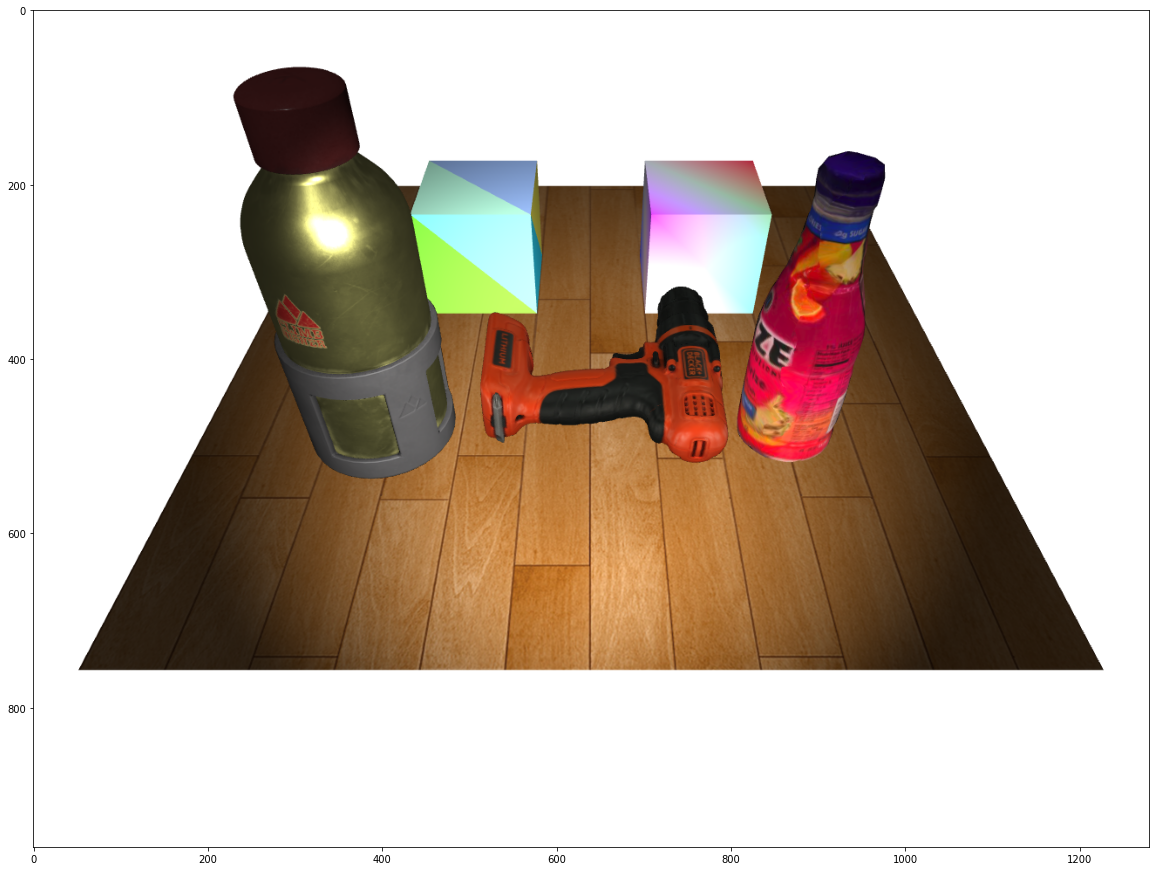

NoSuchDisplayException: ignored

In [115]:
%cd /content/pyrender/examples/

"""Examples of using pyrender for viewing and offscreen rendering.
"""
import pyglet
# pyglet.options['shadow_window'] = False
import os
import numpy as np
import trimesh

from pyrender import PerspectiveCamera,\
                     DirectionalLight, SpotLight, PointLight,\
                     MetallicRoughnessMaterial,\
                     Primitive, Mesh, Node, Scene,\
                     OffscreenRenderer

#==============================================================================
# Mesh creation
#==============================================================================

#------------------------------------------------------------------------------
# Creating textured meshes from trimeshes
#------------------------------------------------------------------------------

# Fuze trimesh
fuze_trimesh = trimesh.load('./models/fuze.obj')
fuze_mesh = Mesh.from_trimesh(fuze_trimesh)

# Drill trimesh
drill_trimesh = trimesh.load('./models/drill.obj')
drill_mesh = Mesh.from_trimesh(drill_trimesh)
drill_pose = np.eye(4)
drill_pose[0,3] = 0.1
drill_pose[2,3] = -np.min(drill_trimesh.vertices[:,2])

# Wood trimesh
wood_trimesh = trimesh.load('./models/wood.obj')
wood_mesh = Mesh.from_trimesh(wood_trimesh)

# Water bottle trimesh
bottle_gltf = trimesh.load('./models/WaterBottle.glb')
bottle_trimesh = bottle_gltf.geometry[list(bottle_gltf.geometry.keys())[0]]
bottle_mesh = Mesh.from_trimesh(bottle_trimesh)
bottle_pose = np.array([
    [1.0, 0.0,  0.0, 0.1],
    [0.0, 0.0, -1.0, -0.16],
    [0.0, 1.0,  0.0, 0.13],
    [0.0, 0.0,  0.0, 1.0],
])

#------------------------------------------------------------------------------
# Creating meshes with per-vertex colors
#------------------------------------------------------------------------------
boxv_trimesh = trimesh.creation.box(extents=0.1*np.ones(3))
boxv_vertex_colors = np.random.uniform(size=(boxv_trimesh.vertices.shape))
boxv_trimesh.visual.vertex_colors = boxv_vertex_colors
boxv_mesh = Mesh.from_trimesh(boxv_trimesh, smooth=False)

#------------------------------------------------------------------------------
# Creating meshes with per-face colors
#------------------------------------------------------------------------------
boxf_trimesh = trimesh.creation.box(extents=0.1*np.ones(3))
boxf_face_colors = np.random.uniform(size=boxf_trimesh.faces.shape)
boxf_trimesh.visual.face_colors = boxf_face_colors
boxf_mesh = Mesh.from_trimesh(boxf_trimesh, smooth=False)

#------------------------------------------------------------------------------
# Creating meshes from point clouds
#------------------------------------------------------------------------------
points = trimesh.creation.icosphere(radius=0.05).vertices
point_colors = np.random.uniform(size=points.shape)
points_mesh = Mesh.from_points(points, colors=point_colors)

#==============================================================================
# Light creation
#==============================================================================

direc_l = DirectionalLight(color=np.ones(3), intensity=1.0)
spot_l = SpotLight(color=np.ones(3), intensity=10.0,
                   innerConeAngle=np.pi/16, outerConeAngle=np.pi/6)
point_l = PointLight(color=np.ones(3), intensity=10.0)

#==============================================================================
# Camera creation
#==============================================================================

cam = PerspectiveCamera(yfov=(np.pi / 3.0))
cam_pose = np.array([
    [0.0,  -np.sqrt(2)/2, np.sqrt(2)/2, 0.5],
    [1.0, 0.0,           0.0,           0.0],
    [0.0,  np.sqrt(2)/2,  np.sqrt(2)/2, 0.4],
    [0.0,  0.0,           0.0,          1.0]
])

#==============================================================================
# Scene creation
#==============================================================================

scene = Scene(ambient_light=np.array([0.02, 0.02, 0.02, 1.0]))

#==============================================================================
# Adding objects to the scene
#==============================================================================

#------------------------------------------------------------------------------
# By manually creating nodes
#------------------------------------------------------------------------------
fuze_node = Node(mesh=fuze_mesh, translation=np.array([0.1, 0.15, -np.min(fuze_trimesh.vertices[:,2])]))
scene.add_node(fuze_node)
boxv_node = Node(mesh=boxv_mesh, translation=np.array([-0.1, 0.10, 0.05]))
scene.add_node(boxv_node)
boxf_node = Node(mesh=boxf_mesh, translation=np.array([-0.1, -0.10, 0.05]))
scene.add_node(boxf_node)

#------------------------------------------------------------------------------
# By using the add() utility function
#------------------------------------------------------------------------------
drill_node = scene.add(drill_mesh, pose=drill_pose)
bottle_node = scene.add(bottle_mesh, pose=bottle_pose)
wood_node = scene.add(wood_mesh)
direc_l_node = scene.add(direc_l, pose=cam_pose)
spot_l_node = scene.add(spot_l, pose=cam_pose)

#==============================================================================
# Using the viewer with a default camera
#==============================================================================

# needs a screen
# v = Viewer(scene, shadows=True)

#==============================================================================
# Using the viewer with a pre-specified camera
#==============================================================================

# needs a screen
# cam_node = scene.add(cam, pose=cam_pose)
# v = Viewer(scene, central_node=drill_node)

#==============================================================================
# Rendering offscreen from that camera
#==============================================================================

cam_node = scene.add(cam, pose=cam_pose)
r = OffscreenRenderer(viewport_width=640*2, viewport_height=480*2)
color, depth = r.render(scene)
r.delete()

import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(color)
plt.show()

pyrender.Viewer(scene)

/content


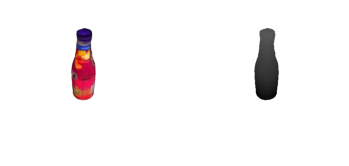

In [39]:
%cd /content/
import trimesh 
import pyrender 
import numpy as np
import matplotlib.pyplot as plt
fuze_trimesh = trimesh.load('pyrender/examples/models/fuze.obj')
mesh = pyrender.Mesh.from_trimesh(fuze_trimesh)
scene = pyrender.Scene()
scene.add(mesh)
#pyrender.Viewer(scene, use_raymond_lighting=True)
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
s = np.sqrt(2)/2
camera_pose = np.array([[0.0, -s,   s,   0.3],[1.0,  0.0, 0.0, 0.0], [0.0,  s,   s,   0.35],[0.0,  0.0, 0.0, 1.0],])

scene.add(camera, pose=camera_pose)

light = pyrender.SpotLight(color=np.ones(3), intensity=3.0, innerConeAngle=np.pi/16.0,outerConeAngle=np.pi/6.0)

scene.add(light, pose=camera_pose)

r = pyrender.OffscreenRenderer(400, 400)

color, depth = r.render(scene)

plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

mesh.primitives

Creating Triangular Meshes

Simple Construction 



In [40]:
%cd /content/
import trimesh 
import pyrender
import numpy as np

tm = trimesh.load('pyrender/examples/models/fuze.obj')
m = pyrender.Mesh.from_trimesh(tm)
m.primitives #primitive represent geometry that can be drawn to the screen. 쉽게 말하면 rendering 할 수 있는 객체.

/content


/content


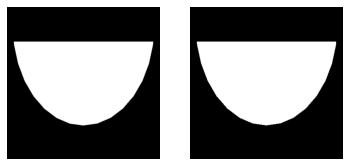

In [113]:
%cd /content/
import trimesh 
import pyrender
import numpy as np
tms = trimesh.creation.cylinder(radius=0.5, height=1, sections=None, segment=None, transform=None)
tms.visual.vertex_colors = [1.0, 0.0, 0.0]
tfs = np.tile(np.eye(4), (len(pts), 1, 1))
tfs[:,:3,3] = pts
m = pyrender.Mesh.from_trimesh(tms, poses=tfs)



scene = pyrender.Scene()
scene.add(m)
#pyrender.Viewer(scene, use_raymond_lighting=True)
camera = pyrender.OrthographicCamera(xmag=0.5, ymag=0.5)
s = np.sqrt(2)/2
camera_pose = np.array([[0.0, -s,   s,   0.3],[1.0,  0.0, 0.0, 0.0], [0.0,  s,   s,   0.35],[0.0,  0.0, 0.0, 1.0],])

scene.add(camera, pose=camera_pose)

light = pyrender.SpotLight(color=np.ones(3), intensity=3.0, innerConeAngle=np.pi/16.0,outerConeAngle=np.pi/6.0)

scene.add(light, pose=camera_pose)

r = pyrender.OffscreenRenderer(400, 400)

color, depth = r.render(scene)

plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

m.primitives

#trimesh.creation.으로 만든건 어케 그리지?

/content


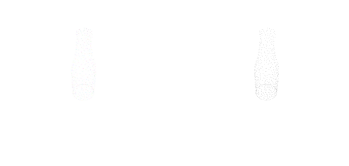

In [60]:
%cd /content/
import trimesh 
import pyrender
import numpy as np
tm = trimesh.load('pyrender/examples/models/fuze.obj')
tm.visual.vertex_colors = np.random.uniform(size=tm.vertices.shape)
tm.visual.face_colors = np.random.uniform(size=tm.faces.shape)
m = pyrender.Mesh.from_trimesh(tm)
pts = tm.vertices.copy()
colors = np.random.uniform(size=pts.shape)
m = pyrender.Mesh.from_points(pts, colors=colors)


scene = pyrender.Scene()
scene.add(m)
#pyrender.Viewer(scene, use_raymond_lighting=True)
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
s = np.sqrt(2)/2
camera_pose = np.array([[0.0, -s,   s,   0.3],[1.0,  0.0, 0.0, 0.0], [0.0,  s,   s,   0.35],[0.0,  0.0, 0.0, 1.0],])
scene.add(camera, pose=camera_pose)
light = pyrender.SpotLight(color=np.ones(3), intensity=3.0, innerConeAngle=np.pi/16.0,outerConeAngle=np.pi/6.0)
scene.add(light, pose=camera_pose)
r = pyrender.OffscreenRenderer(600, 600)
color, depth = r.render(scene)

plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()

/content


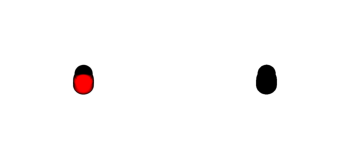

In [85]:
%cd /content/
import trimesh 
import pyrender
import numpy as np

sm = trimesh.creation.uv_sphere(radius=0.1)
sm.visual.vertex_colors = [1.0, 0.0, 0.0]
tfs = np.tile(np.eye(4), (len(pts), 1, 1))
tfs[:,:3,3] = pts
m = pyrender.Mesh.from_trimesh(sm, poses=tfs)
scene = pyrender.Scene()
scene.add(m)
camera = pyrender.OrthographicCamera(xmag=1.0, ymag=1.0)
s = np.sqrt(2)/2
camera_pose = np.array([[0.0, -s,   s,   0.3],[1.0,  0.0, 0.0, 0.0], [0.0,  s,   s,   0.35],[0.0,  0.0, 0.0, 1.0],])
scene.add(camera, pose=camera_pose)
light = pyrender.SpotLight(color=np.ones(3), intensity=3.0, innerConeAngle=np.pi/16.0,outerConeAngle=np.pi/6.0)
scene.add(light, pose=camera_pose)
r = pyrender.OffscreenRenderer(600, 600)
color, depth = r.render(scene)

plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(color)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(depth, cmap=plt.cm.gray_r)
plt.show()